# Import all the libraries

In [138]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from sklearn.preprocessing import *
from sklearn.linear_model import *

import matplotlib.pyplot as plt
from darts import *
from darts.dataprocessing.transformers import *
from darts.models import *
from darts.metrics import *
from darts.datasets import *
from darts.utils.statistics import *
from darts.utils.timeseries_generation import *
from darts.utils.missing_values import fill_missing_values
from backtesting.test import EURUSD


# Load the TimeSeries dataframe

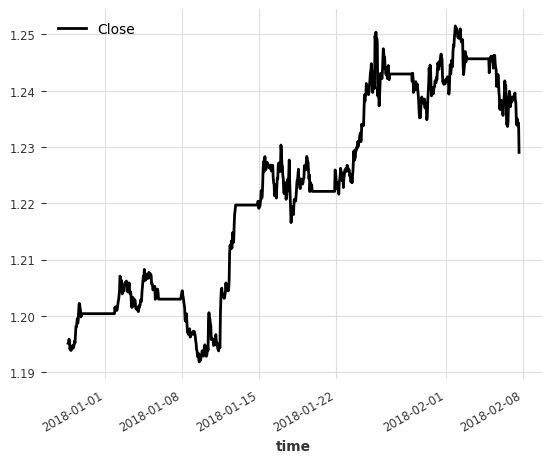

In [139]:
data = EURUSD.copy()
data = data[['Close']]
# extract only the last 1 month of data
data = data.iloc[-24*7*4:]

# data.plot()
eur_usd_series = TimeSeries.from_dataframe(data, value_cols=['Close'], freq='H',fill_missing_dates=True)
eur_usd_series = fill_missing_values(eur_usd_series, method="ffill", limit_direction="forward")
eur_usd_series.plot()

# Classical Models

Training model Theta
model Theta(seasonality_period=168) obtains MAPE: 0.34%
Training model ExponentialSmoothing
model ExponentialSmoothing(seasonal_periods=168) obtains MAPE: 0.68%


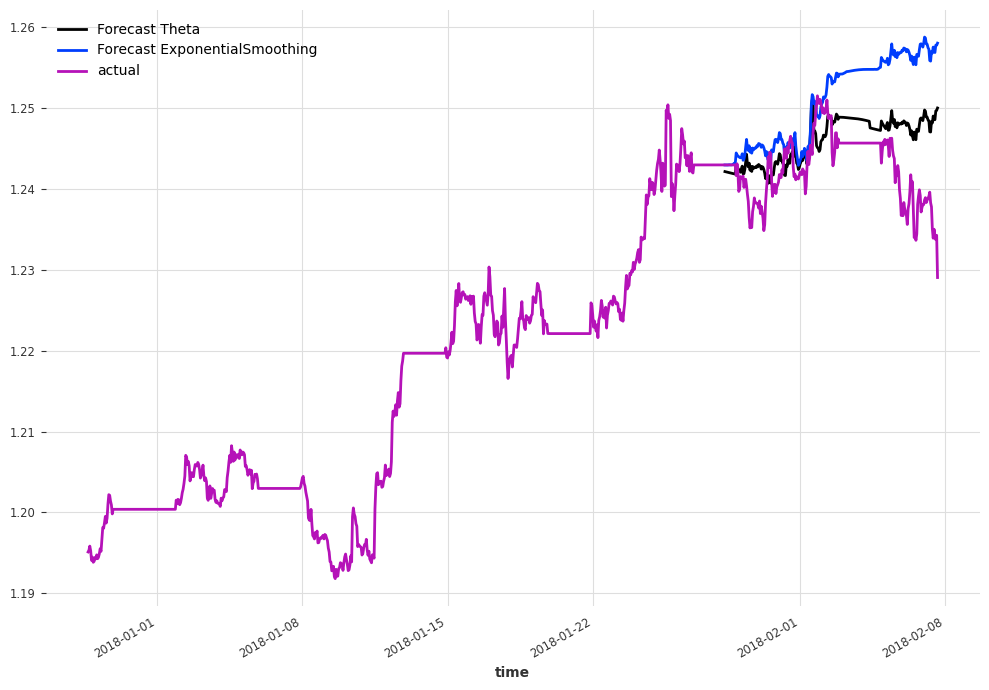

In [153]:
train, val = eur_usd_series.split_before(0.75)

models = {
    "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    # "LinearRegression": LinearRegressionModel(lags=24*7),
    # "BayesianRidge": RegressionModel(lags=24*7, model=BayesianRidge()),
    # "XGBModel": XGBModel(lags=24*7),
    # "LightGBMModel": LightGBMModel(lags=24*7),
#     "DriftSeasonalEnsemble": RegressionEnsembleModel(
#     forecasting_models=[NaiveDrift(), NaiveSeasonal(24*7)], 
#     regression_train_n_points=200
# ),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast.plot(label="Forecast {}".format(name))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()

# Classical Models With MinMaxScaler

Training model Theta
model Theta(seasonality_period=168) obtains MAPE: 0.32%
Training model ExponentialSmoothing
model ExponentialSmoothing(seasonal_periods=168) obtains MAPE: 0.66%
Training model LinearRegression
model LinearRegression() obtains MAPE: 0.76%


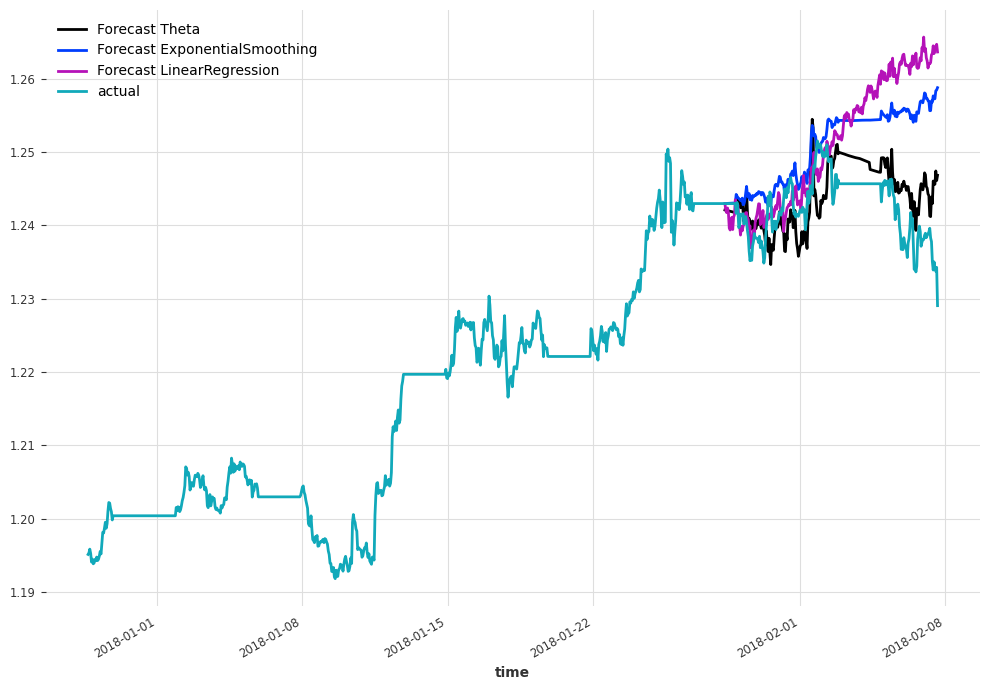

In [141]:
train, val = eur_usd_series.split_before(0.75)

transformer = Scaler(MinMaxScaler(feature_range=(0.1, 1)))
train = transformer.fit_transform(train)
val = transformer.transform(val)


models = {
    "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    "LinearRegression": LinearRegressionModel(lags=24*7),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast_original = transformer.inverse_transform(forecast)
    forecast_original.plot(label="Forecast {}".format(name))
    
    val_original = transformer.inverse_transform(val)
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val_original, forecast_original)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()

# Classical Models with PowerTransformer

Training model Theta
model Theta(seasonality_period=168) obtains MAPE: 0.48%
Training model ExponentialSmoothing
model ExponentialSmoothing(seasonal_periods=168) obtains MAPE: 0.30%
Training model LinearRegression
model LinearRegression() obtains MAPE: 1.06%


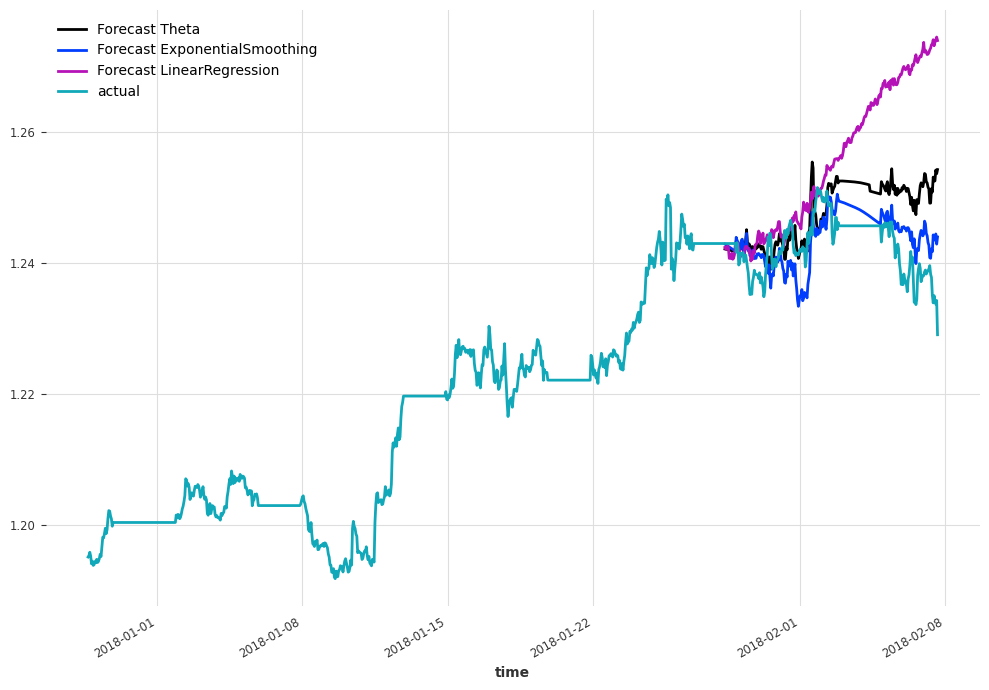

In [142]:
train, val = eur_usd_series.split_before(0.75)

transformer = BoxCox()
train = transformer.fit_transform(train)
val = transformer.transform(val)


models = {
    "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    "LinearRegression": LinearRegressionModel(lags=24*7),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast_original = transformer.inverse_transform(forecast)
    forecast_original.plot(label="Forecast {}".format(name))
    
    val_original = transformer.inverse_transform(val)
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val_original, forecast_original)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()

# Classical Models with GridSearch Param Optimization

Training model XGBoost
model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...) obtains MAPE: 0.27%


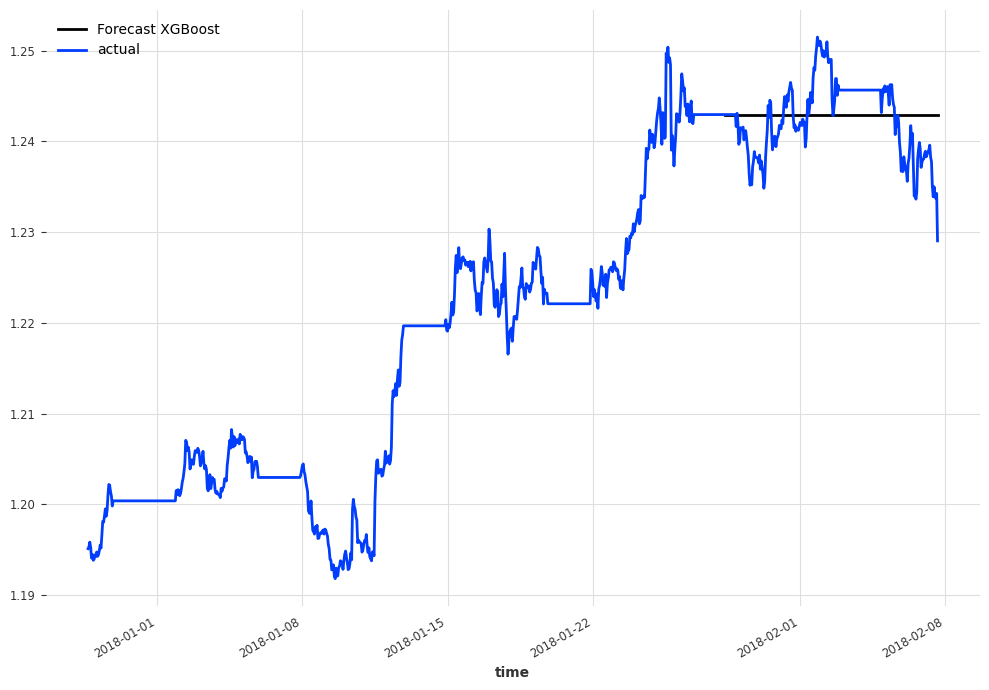

In [143]:
train, val = eur_usd_series.split_before(0.75)

transformer = BoxCox()
train = transformer.fit_transform(train)
val = transformer.transform(val)

# theta_optim = Theta.gridsearch(
#     parameters={
#         'seasonality_period': [24*7,24*7*2]
#     },
#     series=train,
#     metric=mape,
#     forecast_horizon=len(val),
#     start=None,
# )[0]

# exponential_smoothing_optim = ExponentialSmoothing.gridsearch(
#     parameters={
#         'seasonal_periods': [24*7]
#     },
#     series=train,
#     metric=mape,
#     forecast_horizon=len(val),
#     start=None,
# )[0]

# linear_regression_optim = LinearRegressionModel.gridsearch(
#     parameters={
#         'lags': [24*7],
#     },
#     series=train,
#     metric=mape,
#     forecast_horizon=len(val),
#     start=None,
# )[0]


# print(linear_regression_optim)

models = {
    # "Theta": Theta(seasonality_period=24*7),
    # 'Transformer': TransformerModel(
    #     input_chunk_length=24*7,
    #     output_chunk_length=24*2,
    #     log_tensorboard=True,
    #     random_state=42,
    #     n_epochs = 2,
    # ),
    # "ExponentialSmoothing": exponential_smoothing_optim,
    # "LinearRegression": linear_regression_optim,
    # "NBEATSModel": NBEATSModel(
    #     input_chunk_length=24*7,
    #     output_chunk_length=24*2,
    #     n_epochs = 2,
    #     activation='LeakyReLU',
    #     ),
    # "Prophet": Prophet(),
    "XGBoost": XGBModel(lags=365,
                        output_chunk_length = 365,
                        random_state=0,
                        multi_models=False,
                        ),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast_original = transformer.inverse_transform(forecast)
    forecast_original.plot(label="Forecast {}".format(name))

    val_original = transformer.inverse_transform(val)
    print("model {} obtains MAPE: {:.2f}%".format(
        model, mape(val_original, forecast_original)))

eur_usd_series.plot(label="actual")
fig.tight_layout()
plt.show()


# TimeSeriesSplit

## Load the dataset

In [144]:

EURUSD_H1_2007_2023 = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
EURUSD_H1_2007_2023 = EURUSD_H1_2007_2023.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
# rename the columns
EURUSD_H1_2007_2023 = EURUSD_H1_2007_2023.rename(columns={'<DATE>': 'Date',
                                '<TIME>': 'Time',
                                '<OPEN>': 'Open',
                                '<HIGH>': 'High',
                                '<LOW>': 'Low',
                                '<CLOSE>': 'Close'})
# combine the date and time columns
EURUSD_H1_2007_2023['time'] = EURUSD_H1_2007_2023['Date'] + ' ' + EURUSD_H1_2007_2023['Time']
# convert the date_time column to datetime
EURUSD_H1_2007_2023['time'] = pd.to_datetime(EURUSD_H1_2007_2023['time'], format='%Y%m%d %H:%M:%S.%f')
# remove the date and time columns
EURUSD_H1_2007_2023 = EURUSD_H1_2007_2023.drop(['Date', 'Time'], axis=1)
EURUSD_H1_2007_2023.index = EURUSD_H1_2007_2023['time']
EURUSD_H1_2007_2023_CLOSE = EURUSD_H1_2007_2023[['Close']]


ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=168, random_state=0)

Model ExponentialSmoothing obtains MAPE: 0.95%


RegressionModel(lags=168, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, add_encoders=None, model=BayesianRidge(), multi_models=True, use_static_covariates=True)

Model BayesianRidge obtains MAPE: 1.49%


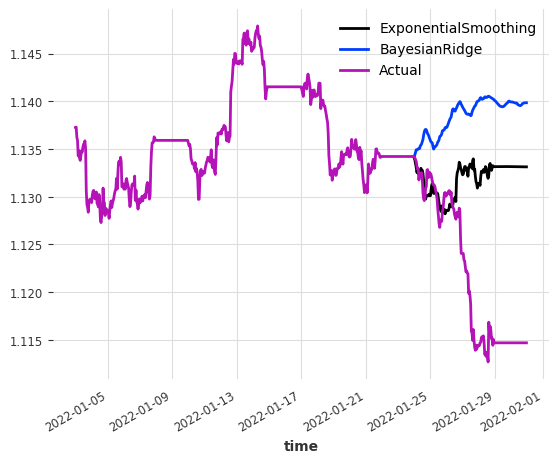

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=168, random_state=0)

Model ExponentialSmoothing obtains MAPE: 2.37%


RegressionModel(lags=168, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, add_encoders=None, model=BayesianRidge(), multi_models=True, use_static_covariates=True)

Model BayesianRidge obtains MAPE: 3.33%


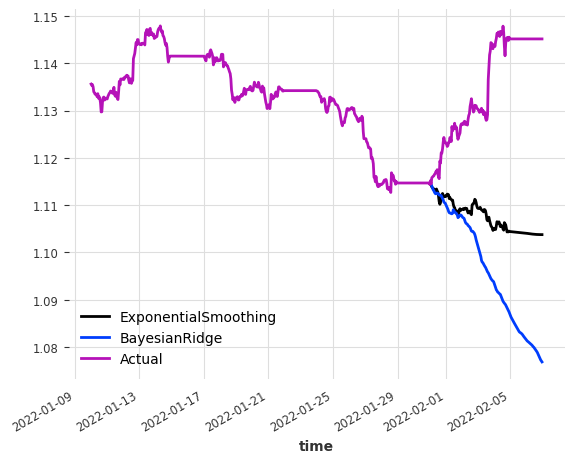

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=168, random_state=0)

Model ExponentialSmoothing obtains MAPE: 0.89%


RegressionModel(lags=168, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, add_encoders=None, model=BayesianRidge(), multi_models=True, use_static_covariates=True)

Model BayesianRidge obtains MAPE: 1.70%


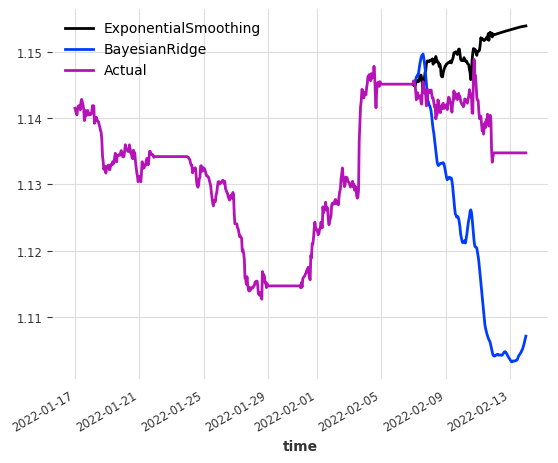

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=168, random_state=0)

Model ExponentialSmoothing obtains MAPE: 0.19%


RegressionModel(lags=168, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, add_encoders=None, model=BayesianRidge(), multi_models=True, use_static_covariates=True)

Model BayesianRidge obtains MAPE: 0.25%


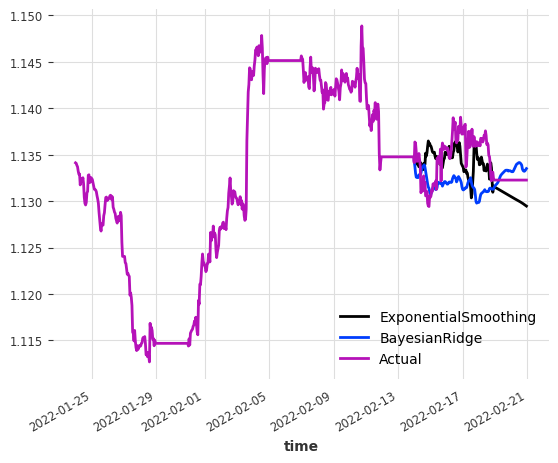

End of iteration 3


In [279]:
import warnings
import logging
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn import linear_model

warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

local_eur_usd_data_dict = {
    # '2010' : EURUSD_H1_2007_2023_CLOSE['2010'],
    # '2011' : EURUSD_H1_2007_2023_CLOSE['2011'],
    # '2012' : EURUSD_H1_2007_2023_CLOSE['2012'],
    # '2013' : EURUSD_H1_2007_2023_CLOSE['2013'],
    # '2014' : EURUSD_H1_2007_2023_CLOSE['2014'],
    # '2015' : EURUSD_H1_2007_2023_CLOSE['2015'],
    # '2016' : EURUSD_H1_2007_2023_CLOSE['2016'],
    # '2017' : EURUSD_H1_2007_2023_CLOSE['2017'],
    # '2018' : EURUSD_H1_2007_2023_CLOSE['2018'],
    # '2019' : EURUSD_H1_2007_2023_CLOSE['2019'],
    # '2020' : EURUSD_H1_2007_2023_CLOSE['2020'],
    # '2021' : EURUSD_H1_2007_2023_CLOSE['2021'],
    '2022': EURUSD_H1_2007_2023_CLOSE.loc['2022'],
}

models = {
    # "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    "BayesianRidge": RegressionModel(lags=24*7, model=BayesianRidge(),output_chunk_length = 7),
    # "LassoCV": RegressionModel(lags=24*7, model=linear_model.LassoCV()),
    # "LinearRegression": LinearRegressionModel(lags=24*7),
    # "EnsembleThetaExpo": RegressionEnsembleModel(
    #     forecasting_models=[Theta(seasonality_period=24*7), ExponentialSmoothing(seasonal_periods=24*7)],
    #     regression_train_n_points=100),
    # "XGBModel": XGBModel(lags=24*7),
    # "LightGBMModel": LightGBMModel(lags=24*7),
    #     "DriftSeasonalEnsemble": RegressionEnsembleModel(
    #     forecasting_models=[NaiveDrift(), NaiveSeasonal(24*7)],
    #     regression_train_n_points=200
    # ),
}

for i, (key, value) in enumerate(local_eur_usd_data_dict.items()):
    local_series = TimeSeries.from_dataframe(
        value, value_cols=['Close'], freq='H', fill_missing_dates=True)
    local_series = fill_missing_values(
        local_series, method="ffill", limit_direction="forward")
    local_df = local_series.pd_dataframe()

    splitter = SlidingWindowSplitter(
        window_length=24*7*3, fh=np.arange(1, 169), step_length=168)
    for j, (train_idx, test_idx) in enumerate(splitter.split(local_df)):
        train_df = local_df.iloc[train_idx]
        test_df = local_df.iloc[test_idx]
        
        train_ts = TimeSeries.from_dataframe(train_df)
        test_ts = TimeSeries.from_dataframe(test_df)

        # transformer = BoxCox()
        transformer = Scaler(MinMaxScaler(feature_range=(0.1, 1)))
        train_transformed = transformer.fit_transform(train_ts)

        for model_name, model in models.items():
            model.fit(train_transformed)
            fcast_transformed = model.predict(len(test_ts))
            fcast = transformer.inverse_transform(fcast_transformed)

            print("Model {} obtains MAPE: {:.2f}%".format(
                model_name, mape(test_ts, fcast)))

            fcast.plot(label="{}".format(model_name))
            
        # concat train_df and test_df
        train_test_df = pd.concat([train_df, test_df])    
        train_test_ts = TimeSeries.from_dataframe(train_test_df)
        train_test_ts.plot(label="Actual")
        # exit plot for a new plot in a new loop
        # give the plot a title based on the year and month
        # plt.title("EURUSD_H1_2007_2023_CLOSE_{}".format(key))
        
        # plt.legend()
        plt.show()
        if j == 3:
            break
    print("End of iteration {}".format(j))


## TimeSeriesSplit with Past Covariates

In [247]:
EURUSD_H1_2007_2023

,Open,High,Low,Close,time
time,,,,,
2007-02-21 00:00:00,1.31340,1.31480,1.31320,1.31440,2007-02-21 00:00:00
2007-02-21 01:00:00,1.31430,1.31480,1.31390,1.31440,2007-02-21 01:00:00
2007-02-21 02:00:00,1.31450,1.31480,1.31410,1.31440,2007-02-21 02:00:00
2007-02-21 03:00:00,1.31450,1.31480,1.31360,1.31360,2007-02-21 03:00:00
2007-02-21 04:00:00,1.31350,1.31480,1.31340,1.31360,2007-02-21 04:00:00
...,...,...,...,...,...
2023-04-24 17:00:00,1.10237,1.10370,1.10207,1.10294,2023-04-24 17:00:00
2023-04-24 18:00:00,1.10294,1.10323,1.10206,1.10260,2023-04-24 18:00:00
2023-04-24 19:00:00,1.10260,1.10342,1.10249,1.10340,2023-04-24 19:00:00


Training: 0it [00:00, ?it/s]

BlockRNNModel(model=RNN, hidden_dim=25, n_rnn_layers=20, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=504, output_chunk_length=168)

Got here


Predicting: 0it [00:00, ?it/s]

Model BlockRNNModel obtains MAPE: 1.62%


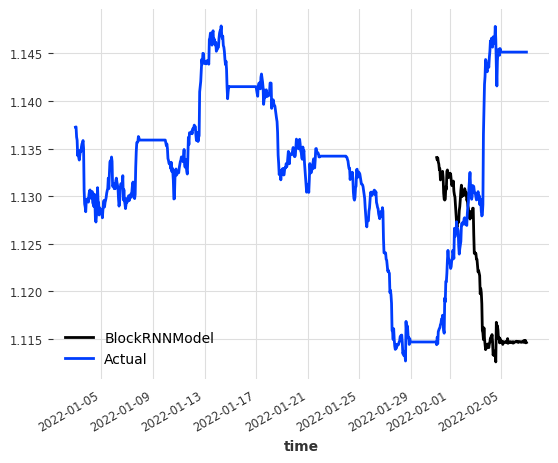

Training: 0it [00:00, ?it/s]

BlockRNNModel(model=RNN, hidden_dim=25, n_rnn_layers=20, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=504, output_chunk_length=168)

Got here


Predicting: 0it [00:00, ?it/s]

Model BlockRNNModel obtains MAPE: 1.16%


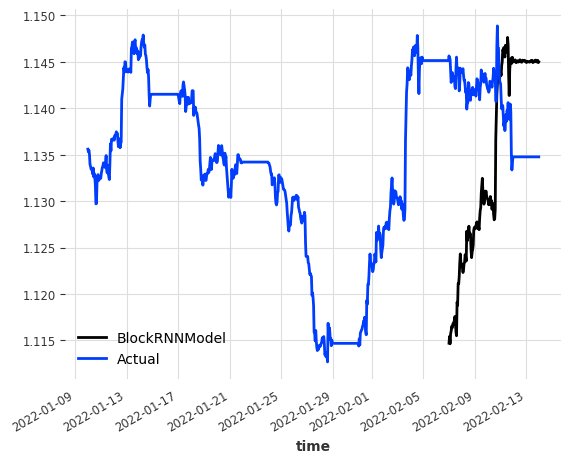

Training: 0it [00:00, ?it/s]

BlockRNNModel(model=RNN, hidden_dim=25, n_rnn_layers=20, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=504, output_chunk_length=168)

Got here


Predicting: 0it [00:00, ?it/s]

Model BlockRNNModel obtains MAPE: 0.52%


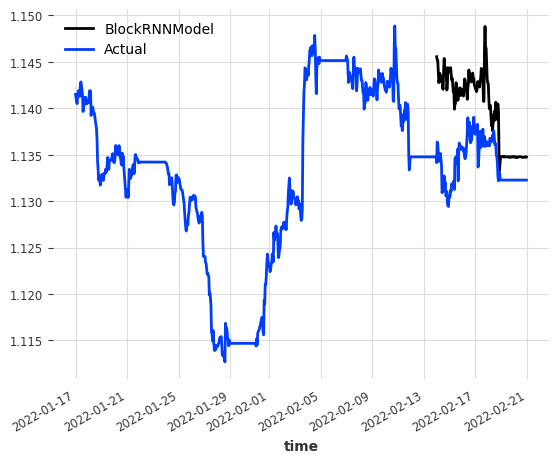

End of iteration 2


In [311]:
import warnings
import logging
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn import linear_model

warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

local_eur_usd_data_dict = {
    # '2010' : EURUSD_H1_2007_2023['2010'],
    # '2011' : EURUSD_H1_2007_2023['2011'],
    # '2012' : EURUSD_H1_2007_2023['2012'],
    # '2013' : EURUSD_H1_2007_2023['2013'],
    # '2014' : EURUSD_H1_2007_2023['2014'],
    # '2015' : EURUSD_H1_2007_2023['2015'],
    # '2016' : EURUSD_H1_2007_2023['2016'],
    # '2017' : EURUSD_H1_2007_2023['2017'],
    # '2018' : EURUSD_H1_2007_2023['2018'],
    # '2019' : EURUSD_H1_2007_2023['2019'],
    # '2020' : EURUSD_H1_2007_2023['2020'],
    # '2021' : EURUSD_H1_2007_2023['2021'],
    '2022': EURUSD_H1_2007_2023.loc['2022'],
}

models = {
    # "Theta": Theta(seasonality_period=24*7),
    # "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    # "BayesianRidge": RegressionModel(lags=None, 
    #                                  model=BayesianRidge(),
    #                                 #  lags_past_covariates= 504,
    #                                  lags_past_covariates=[-5, -4, -3, -2, -1]
                                   
    #                                  ),
    "BlockRNNModel": BlockRNNModel(input_chunk_length=504, 
                                      output_chunk_length=168, 
                                      n_rnn_layers=20
                                      )
                                      
        
}

for i, (key, value) in enumerate(local_eur_usd_data_dict.items()):
    local_series = TimeSeries.from_dataframe(
        value, value_cols=['Open', 'High', 'Low', 'Close'], freq='H', fill_missing_dates=True)
    local_series = fill_missing_values(
        local_series, method="ffill", limit_direction="forward")
    
    local_series = local_series.add_datetime_attribute('hour')
    local_series = local_series.add_datetime_attribute('day')
    local_series = local_series.add_datetime_attribute('month')
    local_series = local_series.add_datetime_attribute('year')
    
    local_df = local_series.pd_dataframe()
 


    splitter = SlidingWindowSplitter(
        window_length=24*7*4, fh=np.arange(1, 169), step_length=168)
    for j, (train_idx, test_idx) in enumerate(splitter.split(local_df)):
        train_df = local_df.iloc[train_idx]
        test_df = local_df.iloc[test_idx]
        
        # concat train_df and test_df
        train_test_df = pd.concat([train_df, test_df])    
        train_test_ts = TimeSeries.from_dataframe(train_test_df)
        
        
        train_ts = TimeSeries.from_dataframe(train_df)
        test_ts = TimeSeries.from_dataframe(test_df)
        
        
        # Initialize past covariates extracting columns Open, High, Low, Close
        past_covariates_df = train_df[['Open', 'High', 'Low']]
        past_covariates_ts = TimeSeries.from_dataframe(past_covariates_df)
        # Scale the past covariates
        past_cov_transformer = Scaler(MinMaxScaler(feature_range=(0.1, 1)))
        past_covariates_transformed = past_cov_transformer.fit_transform(past_covariates_ts)
        
        # Future covariates
        future_covariates_df = train_test_df[['hour', 'day', 'month', 'year']]
        future_covariates_ts = TimeSeries.from_dataframe(future_covariates_df)
        # Scale the future covariates
        future_cov_transformer = Scaler(MinMaxScaler(feature_range=(0.1, 1)))
        future_covariates_transformed = future_cov_transformer.fit_transform(future_covariates_ts)
        
        # Prepare the training data        
        actual_train_df = train_df[['Close']]
        actual_train_ts = TimeSeries.from_dataframe(actual_train_df)
        # Scale the target variable
        # transformer = BoxCox()
        transformer = Scaler(MinMaxScaler(feature_range=(0.1, 1)))
        train_transformed = transformer.fit_transform(actual_train_ts)
        
        # Prepare the testing data
        actual_test_df = test_df[['Close']]
        actual_test_ts = TimeSeries.from_dataframe(actual_test_df)
        test_transformed = transformer.transform(actual_test_ts)
        

        for model_name, model in models.items():
            model.fit(train_transformed, 
                      past_covariates=past_covariates_transformed, 
                      epochs=100, 
                    #   future_covariates=future_covariates_transformed
                      )
            print("Got here")
            fcast_transformed = model.predict(len(actual_test_ts),
                                                past_covariates=past_covariates_transformed, 
                                              
                                              )
            fcast = transformer.inverse_transform(fcast_transformed)

            print("Model {} obtains MAPE: {:.2f}%".format(
                model_name, mape(actual_test_ts, fcast)))

            fcast.plot(label="{}".format(model_name))
            
        actual_train_test_ts = TimeSeries.from_dataframe(train_test_df[['Close']])
        actual_train_test_ts.plot(label="Actual")
        # exit plot for a new plot in a new loop
        # give the plot a title based on the year and month
        # plt.title("EURUSD_H1_2007_2023_CLOSE_{}".format(key))
        
        # plt.legend()
        plt.show()
        if j == 2:
            break
    print("End of iteration {}".format(j))


In [252]:
past_covariates

<TimeSeries (DataArray) (time: 8688, component: 7, sample: 1)>
array([[[0.93875353],
        [0.93759686],
        [0.94365325],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.94039497],
        [0.93945656],
        [0.94582043],
        ...,
        [0.        ],
        [0.        ],
        [0.04347826]],

       [[0.94054886],
        [0.93847505],
        [0.94174407],
        ...,
...
        ...,
        [0.66666667],
        [1.        ],
        [0.91304348]],

       [[0.59492177],
        [0.59319145],
        [0.59643963],
        ...,
        [0.66666667],
        [1.        ],
        [0.95652174]],

       [[0.5978969 ],
        [0.59272652],
        [0.59881321],
        ...,
        [0.66666667],
        [1.        ],
        [1.        ]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-01-03 ... 2022-12-30T23:00:00
  * component  (component) object 'Open' 'High' 'Low' ... 'month' 'hour'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [253]:
local_series

<TimeSeries (DataArray) (time: 8688, component: 4, sample: 1)>
array([[[1.13693],
        [1.13742],
        [1.13645],
        [1.13726]],

       [[1.13725],
        [1.13778],
        [1.13687],
        [1.13728]],

       [[1.13728],
        [1.13759],
        [1.13608],
        [1.13622]],

       ...,

       [[1.0701 ],
        [1.07087],
        [1.06944],
        [1.06991]],

       [[1.0699 ],
        [1.07075],
        [1.06916],
        [1.07047]],

       [[1.07048],
        [1.07066],
        [1.06962],
        [1.06976]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-01-03 ... 2022-12-30T23:00:00
  * component  (component) object 'Open' 'High' 'Low' 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None